# Treinamento de Modelos para Precificação de Carbono
Este notebook realiza o treinamento e avaliação de modelos de aprendizado de máquina para prever preços de carbono com base em dados de PIB, GEE e desmatamento.

In [18]:
# Importar bibliotecas necessárias
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error

## 1. Criar diretório de resultados
Certifique-se de que o diretório para salvar os resultados existe.

In [19]:
os.makedirs("results", exist_ok=True)

## 2. Carregar dataset consolidado
Carregue os dados consolidados de PIB, GEE e desmatamento.

In [20]:
df = pd.read_csv("data/generated/carbono_serra_penitente.csv", encoding="utf-8-sig")
display(df.head())

,municipio,ano,pib,GEE_tCO2e,area_desmatada_ha
0,Alto Parnaíba,1985,NaN,81189.241510,NaN
1,Alto Parnaíba,1985,NaN,846250.420751,NaN
2,Alto Parnaíba,1985,NaN,0.000000,NaN
3,Alto Parnaíba,1985,NaN,9934.681447,NaN
4,Alto Parnaíba,1985,NaN,167314.721706,NaN


## 3. Renomear colunas
Renomeie as colunas para compatibilidade com os modelos.

In [21]:
df.rename(columns={"pib": "gdp", "GEE_tCO2e": "total_ghg", "area_desmatada_ha": "shape_Area"}, inplace=True)
display(df.head())

,municipio,ano,gdp,total_ghg,shape_Area
0,Alto Parnaíba,1985,NaN,81189.241510,NaN
1,Alto Parnaíba,1985,NaN,846250.420751,NaN
2,Alto Parnaíba,1985,NaN,0.000000,NaN
3,Alto Parnaíba,1985,NaN,9934.681447,NaN
4,Alto Parnaíba,1985,NaN,167314.721706,NaN


## 4. Carregar preços de carbono
Carregue os preços de carbono do World Bank Carbon Pricing Dashboard.

In [22]:
xlsx_path = "data/raw/data-latest.xlsx"
sheet = "Compliance_Price"
xls = pd.ExcelFile(xlsx_path)
df_price_raw = pd.read_excel(xls, sheet_name=sheet, header=1)
year_cols = [col for col in df_price_raw.columns if (isinstance(col, str) and col.isdigit()) or isinstance(col, int)]
df_price = df_price_raw.melt(id_vars=["Name of the initiative"], value_vars=year_cols, var_name="ano", value_name="carbon_price_usd")
df_price = df_price[df_price["Name of the initiative"] == "EU ETS"]
df_price["ano"] = df_price["ano"].astype(int)
df_price["carbon_price_usd"] = pd.to_numeric(df_price["carbon_price_usd"], errors="coerce")
df_price = df_price[["ano", "carbon_price_usd"]].dropna().drop_duplicates()
display(df_price.head())

,ano,carbon_price_usd
2160,2005,19.04
2302,2006,32.24
2444,2007,1.25
2586,2008,34.48
2728,2009,15.55


## 5. Mesclar preços ao dataframe principal
Mescle os preços de carbono ao dataframe principal com base no ano.

In [23]:
df = df.merge(df_price, on="ano", how="inner")
display(df.head())

,municipio,ano,gdp,total_ghg,shape_Area,carbon_price_usd
0,Alto Parnaíba,2005,61077.081,83816.796630,NaN,19.04
1,Alto Parnaíba,2005,61077.081,802013.492499,NaN,19.04
2,Alto Parnaíba,2005,61077.081,65.381212,NaN,19.04
3,Alto Parnaíba,2005,61077.081,9777.825784,NaN,19.04
4,Alto Parnaíba,2005,61077.081,166495.575653,NaN,19.04


## 6. Selecionar features e target
Selecione as colunas de entrada (features) e saída (target) e remova valores ausentes.

In [24]:
feature_cols = ["total_ghg", "shape_Area", "gdp"]
target_col = "carbon_price_usd"
df = df.dropna(subset=feature_cols + [target_col])
X = df[feature_cols]
y = df[target_col]

## 7. Divisão treino/teste
Divida os dados em conjuntos de treino e teste.

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 8. Padronização dos dados
Padronize os dados de entrada para melhorar o desempenho dos modelos.

In [26]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 9. Treinar e avaliar modelos
Treine múltiplos modelos e avalie o desempenho de cada um.

In [27]:
modelos = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "MLP Regressor": MLPRegressor(max_iter=1000, random_state=42),
    "Lasso": Lasso(alpha=0.01, random_state=42),
    "SVR": SVR(kernel="rbf"),
    "XGBoost": XGBRegressor(random_state=42)
}
results = []
for name, model in modelos.items():
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)
    r2 = r2_score(y_test, preds)
    mse = mean_squared_error(y_test, preds)
    results.append({"model": name, "R2": r2, "MSE": mse})
df_results = pd.DataFrame(results)
display(df_results)

p:\ProjectsPython\trabalho_Felipe_CO2\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


,model,R2,MSE
0,Linear Regression,0.066465,1.206750e+02
1,Random Forest,0.999960,5.110138e-03
2,MLP Regressor,0.277051,9.345324e+01
3,Lasso,0.067486,1.205430e+02
4,SVR,0.114186,1.145063e+02
5,XGBoost,1.000000,2.497366e-08


## 10. Salvar resultados
Salve os resultados em um arquivo CSV.

In [30]:
# Criar diretório de resultados
os.makedirs("results/figures", exist_ok=True)
df_results.to_csv("results/carbon_model_results.csv", index=False)

# Gráficos de Dispersão: Real vs. Previsto

In [31]:
import matplotlib.pyplot as plt

for nome, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    
    plt.figure(figsize=(6, 6))
    plt.scatter(y_test, y_pred, alpha=0.7)
    plt.xlabel("Real")
    plt.ylabel("Previsto")
    plt.title(f"Real vs Previsto - {nome}")
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.tight_layout()
    plt.savefig(f"results/figures/scatter_real_vs_pred_{nome.replace(' ', '_').lower()}.png")
    plt.close()


# Visualizar Figuras Geradas
As figuras geradas durante a execução do código serão exibidas abaixo.

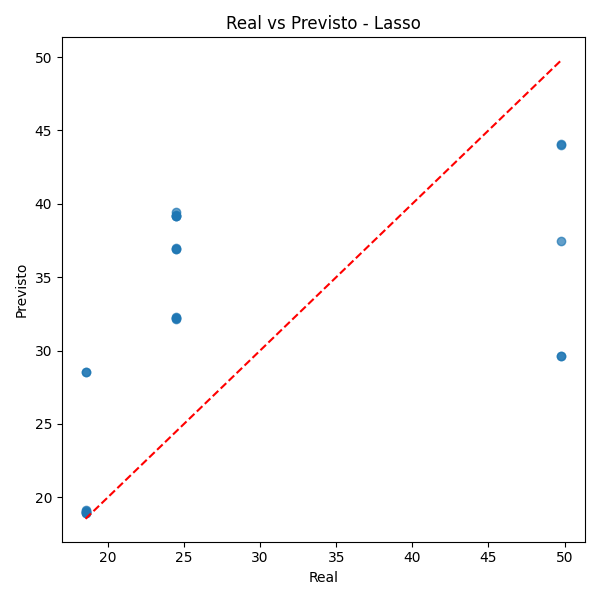

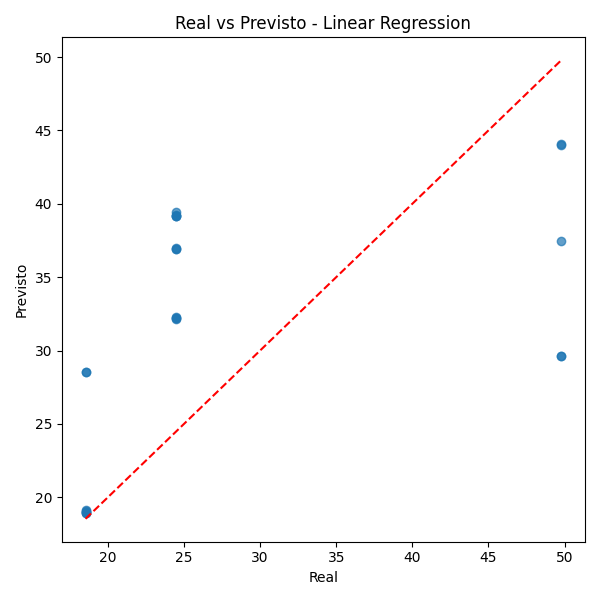

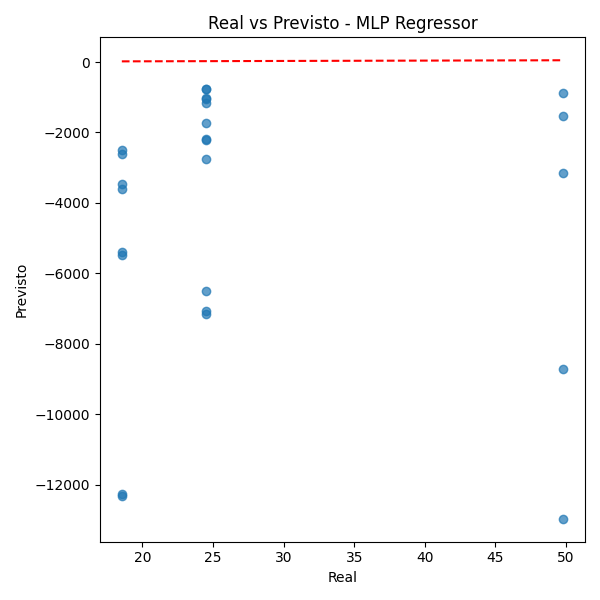

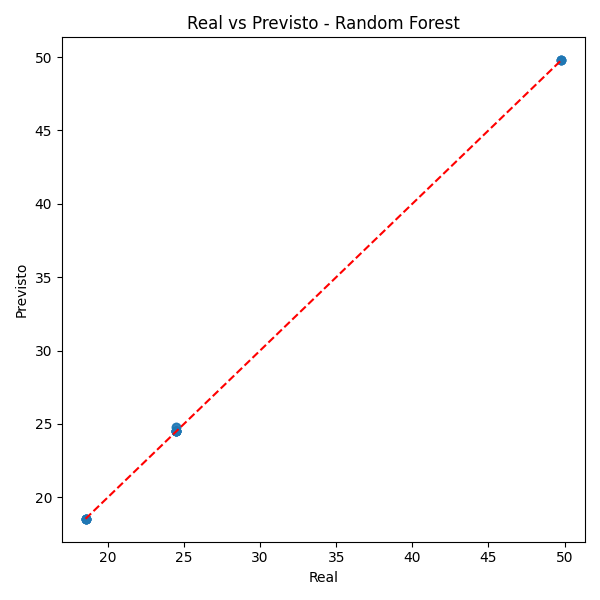

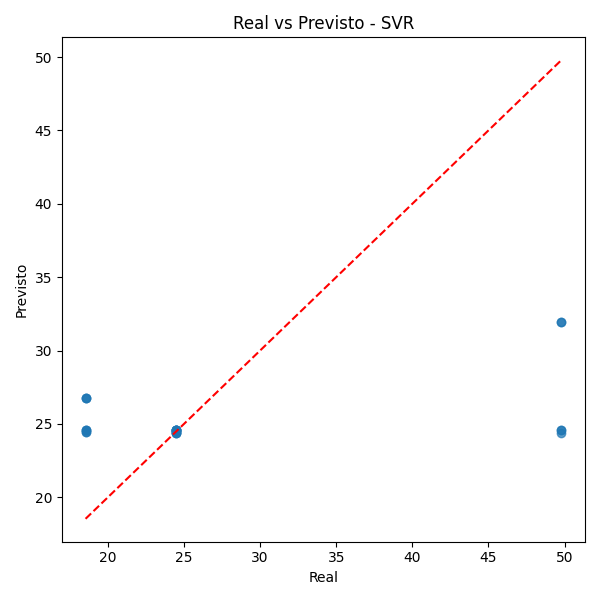

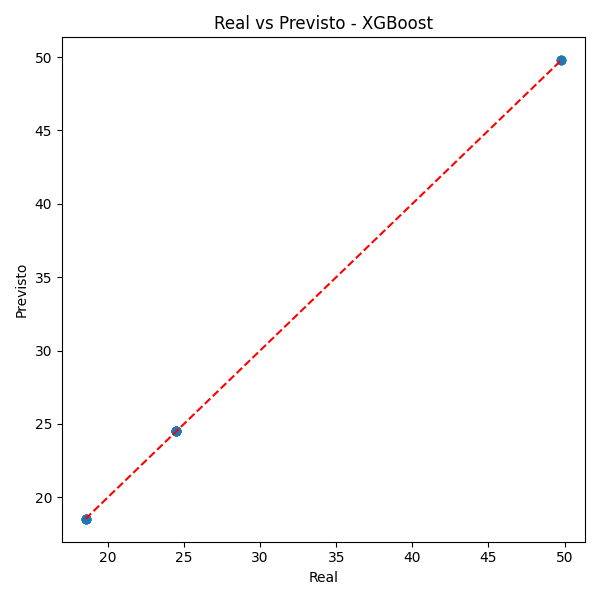

In [32]:
import os
from IPython.display import Image, display

# Diretório das figuras
figures_dir = 'results/figures'

# Listar e exibir figuras
for file_name in os.listdir(figures_dir):
    if file_name.endswith('.png'):
        display(Image(filename=os.path.join(figures_dir, file_name)))